## OCHRE Envelope Analysis 

In [6]:
# Set up
import os
import datetime as dt
import pandas as pd

from ochre import Dwelling, Analysis, CreateFigures
from ochre.FileIO import default_input_path

pd.set_option('display.precision', 3)      # precision in print statements
pd.set_option('expand_frame_repr', False)  # Keeps results on 1 line
pd.set_option('display.max_rows', 30)      # Shows up to 30 rows of data
# pd.set_option('max_columns', None)       # Prints all columns

simulation_name = 'OCHRE Test House'

weather_path = os.path.join(os.path.expanduser('~'), 'NREL', 'Team OCHRE - Documents', 'General', 'Weather',
                            'BuildStock_TMY3_FIPS')
teams_path = os.path.join(os.path.expanduser('~'), 'NREL', 'Team OCHRE - Documents', 'Validation', 'Multifamily',
                          'national_100', 'up00', 'bldg0000001')

dwelling_args = {
    # Timing parameters
    'start_time': dt.datetime(2018, 1, 1, 0, 0),  # year, month, day, hour, minute
    'time_res': dt.timedelta(minutes=60),         # time resolution of the simulation
    'duration': dt.timedelta(days=1),             # duration of the simulation

    # Input parameters - Sample building (uses HPXML file and time series schedule file)
    'properties_file': os.path.join(teams_path, 'in.xml'),
    'schedule_input_file': os.path.join(teams_path, 'schedules.csv'),
    'weather_path': weather_path,

    # Output parameters
    'save_results': False,
}

In [7]:
# create dwelling and linearize radiation/infiltration
linear_args = {
    **dwelling_args,
    'time_res': dt.timedelta(minutes=60),
    'Envelope': {
        # 'save_results': True,  # Saves detailed envelope inputs and states
        'linearize_infiltration': True,
        'external_radiation_method': 'linear',
        'internal_radiation_method': 'linear',
    },
}

house = Dwelling(name=simulation_name, **linear_args)

c:\Users\mblonsky\Miniconda3\envs\ochre_dev\lib\site-packages\scipy\signal\_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


,frequency,magnitude,Minutes,C (kJ/K)
0,5.556e-04,9.908e-04,30.0,3633.564
1,2.778e-04,1.724e-03,60.0,2088.216
2,1.852e-04,2.298e-03,90.0,1566.791
3,1.389e-04,2.765e-03,120.0,1302.052
4,1.111e-04,3.161e-03,150.0,1138.728
5,9.259e-05,3.514e-03,180.0,1024.368
6,7.937e-05,3.842e-03,210.0,937.084


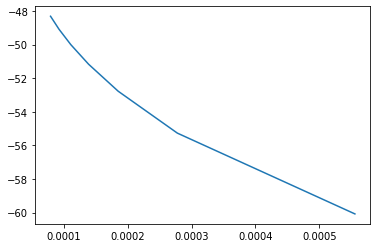

In [74]:
import scipy.signal
import numpy as np

env = house.envelope

# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html
model = scipy.signal.lti(env.A_c, env.B_c[:, -1:], env.C, env.D[:, -1:])
w = [1 / m / 60 for m in range(30, 240, 30)]  # 30 to 240 minute frequencies
w, mag, phase = model.bode(w)

CreateFigures.plt.plot(w, mag)

df = pd.DataFrame((w, mag), index=['frequency', 'magnitude']).T
df['Minutes'] = 1 / df['frequency'] / 60
df['magnitude'] = 10 ** (df['magnitude'] / 20)
df['C (kJ/K)'] = 1 / df['magnitude'] * 3600 / 1000  # kJ / K
df


In [75]:
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html
model = scipy.signal.lti(env.A_c, env.B_c[:, :1], env.C, env.D[:, :1])
w = [1 / m / 60 for m in range(30, 240, 30)]  # 30 to 240 minute frequencies
w, mag, phase = model.bode(w)

# CreateFigures.plt.plot(w, mag)

df = pd.DataFrame((w, mag), index=['frequency', 'magnitude']).T
df['Minutes'] = 1 / df['frequency'] / 60
df['magnitude'] = 10 ** (df['magnitude'] / 20)
df['RC (hours)'] = 1 / df['magnitude']
df


c:\Users\mblonsky\Miniconda3\envs\ochre_dev\lib\site-packages\scipy\signal\_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


,frequency,magnitude,Minutes,RC (hours)
0,5.556e-04,0.029,30.0,34.836
1,2.778e-04,0.055,60.0,18.297
2,1.852e-04,0.081,90.0,12.356
3,1.389e-04,0.106,120.0,9.399
4,1.111e-04,0.130,150.0,7.665
5,9.259e-05,0.153,180.0,6.525
6,7.937e-05,0.175,210.0,5.709


In [56]:
env.A[-1, -1]

0.6079141435798809

In [57]:
env.state_names

['T_EW1', 'T_EW2', 'T_EW3', 'T_EW4', 'T_IW1', 'T_IW2', 'T_IM1', 'T_LIV']

In [58]:
env.input_names

['T_EXT', 'H_EW1', 'H_IM1', 'H_LIV']

In [59]:
env.output_names

['T_LIV']

In [60]:
env.B

array([[5.51429257e-01, 8.55074962e-03, 3.84998670e-06, 8.53163800e-06],
       [2.78755597e-01, 4.25255199e-03, 1.84929537e-05, 4.02360759e-05],
       [8.96023636e-02, 1.19428836e-03, 5.33862401e-05, 1.14017021e-04],
       [6.36390265e-02, 3.97670541e-04, 2.08399073e-04, 4.28262203e-04],
       [4.82457124e-02, 1.45132879e-05, 2.46448466e-04, 5.10115530e-04],
       [3.98759358e-02, 8.59564919e-06, 1.80707430e-04, 3.81977943e-04],
       [1.65090240e-02, 3.84998670e-06, 1.67693120e-03, 9.19417488e-05],
       [5.45570500e-02, 8.53163800e-06, 9.19417488e-05, 1.68849860e-03]])

In [70]:
e = env.B[-1, 0]
e

0.05455705000931139

In [64]:
b = env.B[-1, -1]
1 / b * 3600 / 1000  # kJ / K
b

0.0016884985955297287

In [63]:
env.zones['Indoor'].capacitance

1640.4059006778048